In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
!pip install wordcloud
from wordcloud import WordCloud

# The below updates may be needed to run the wordcloud
# !pip install --upgrade pip
# !pip install --upgrade Pillow

[nltk_data] Downloading package stopwords to /home/peter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/peter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/peter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/peter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [102]:
# Loading the chapter list

pwd = !pwd
path1 = pwd[0] + '/../data/chapters_tokenized.json'
with open(path1, 'r') as json_file:
    chapters_tokenized = json.load(json_file)

In [103]:
path2 = pwd[0] + '/../data/wordcount_df.csv'
count_df = pd.read_csv(path2, header = 0, index_col=0)

# Produce any interesting or relevant analysis as you see fit on the topics represented by each chapter. 

Considerations to discuss:
 - Lemmatization - decided against due to future filtering by TDIDF terms
 - What improvements could be made upon the TFIDF formula in this situation and what effect would this have on the results?

# Calculating TFIDF for each word in each chapter

There was an option to use the package: sklearn.feature_extraction.text.TfidfVectorizer. However, there is an issue with the formula it uses which is intended to stop division by 0. This is something we have avoided already by ensuring we are only analysing words that appear in the text, so I have calculated this based on the word count.

In [114]:
# Importing stopwords

stp = stopwords.words('english')

In [115]:
# Creating custom TDIDF function to apply to the dataframe

def add_tf_idf(count_df, chapters_tokenized, stopwords):
    
    chapter_count = len(chapters_tokenized)
    tfidf_series = []
    
    for index, word in enumerate(count_df['word']):
        
        chapter_number = count_df['chapter_number'][index]
        
        if word in stopwords:
            tf = 0
        else:
            tf = count_df['count'][index]/len(chapters_tokenized[chapter_number-1])
            
        freq = 0
        for chapter in chapters_tokenized:
            if word in chapter:
                freq += 1
        idf = log(chapter_count/freq)
        tf_idf = tf * idf
        
        tfidf_series.append(tf_idf)
        
    return tfidf_series

In [116]:
count_df['tf_idf'] = add_tf_idf(count_df, chapters_tokenized, stp)
count_df

,chapter_number,word,count,tf_idf
0,1,almost,1,0.000403
1,1,overhead,1,0.001144
2,1,was,53,0.000000
3,1,sight,1,0.000187
4,1,top,2,0.000638
...,...,...,...,...
7295,12,character,1,0.001150
7296,12,evidence,3,0.002489
7297,12,globe,1,0.001150
7298,12,any,3,0.000000


# Analysis of the highest scoring TFIDF words in each chapter

In [107]:
# Finding the top elements of the dataframe

def top_n_tfid_terms(df, n):
    
    top_tfid_list = []
    
    for chapter in range(1,13):
        
        chapter_df = df[df['chapter_number']==chapter].nlargest(n, columns = 'tf_idf')
        top_tdidf_terms = chapter_df[['word', 'tf_idf']]
        top_tfid_list.append(top_tdidf_terms)
        
    return top_tfid_list 

top_tdidf_terms_10 = top_n_tfid_terms(count_df, 10)

In [108]:
# Quick inspection of the terms to see if there is correllation to the storylines

top_tdidf_terms_10[0]

,word,tf_idf
288,bats,0.004574
190,key,0.003828
34,dark,0.003431
56,cake,0.003431
225,rabbit-hole,0.003431
338,candle,0.003431
350,poison,0.003431
116,bottle,0.003298
50,eat,0.002820
372,fell,0.002552


# Displaying top scoring TFIDF words in a wordcloud

In [109]:
# Changing the TDIDF data to a format the WordCloud function is expecting

def tfid_to_wordcloud(top_n_tfid_terms):
    tfid_word_cloud = {}
    for i in range(0,12):
        tfid_word_cloud[i] = []
        for index, row in top_n_tfid_terms[i].iterrows():
            word, tfidf = row['word'], row['tf_idf']
            tfid_word_cloud[i].extend([word]*int(round(tfidf,3)*1000))
    return tfid_word_cloud

wordcloud_terms_10 = tfid_to_wordcloud(top_tdidf_terms_10)

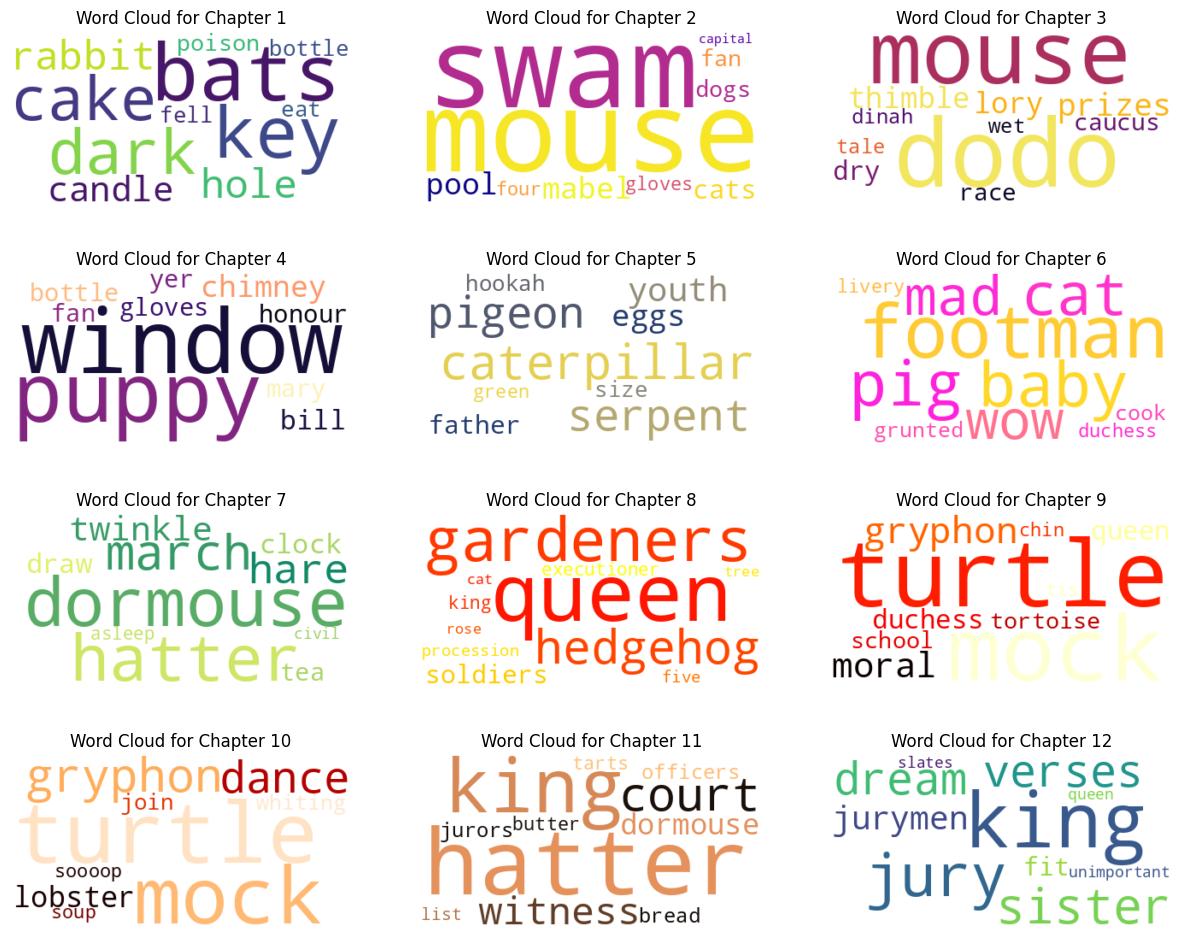

In [110]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))

colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'spring',
             'summer', 'autumn', 'hot', 'gist_heat', 'copper','viridis']

for i, ax in enumerate(axes.flat):
    if i < 12:  
        text = ' '.join(wordcloud_terms_10[i])
        wc = WordCloud(prefer_horizontal = 1, background_color="white", collocations=False, colormap = colormaps[i])
        wc.generate(text)
        ax.imshow(wc, interpolation='bilinear')
        ax.set_title(f"Word Cloud for Chapter {i+1}")
        ax.axis("off")

plt.show()

## - How many terms to include in the word cloud? What defines a chapter?

# Saving top TFIDF terms to analyse sentiment

In [113]:
pwd = !pwd
path1 = pwd[0] + '/../data/top_tdidf_terms_10_list.json'
# Save data to JSON file
with open(path1, "w") as json_file:
    json.dump(top_tdidf_terms_10_list, json_file)

# Following this notebook, please run the python file 'sentiment_pipeline.py'